In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [149]:
df = pd.read_csv('ROP_Optimization_dataset.csv')
df.head()

,Measured Depth m,Weight on Bit kkgf,Average Rotary Speed rpm,Mud Flow In L/min,UCS,Rate of Penetration m/h
0,3008.8,4.4,217.60,2121.4,75.008535,19.2
1,3008.9,4.4,217.45,2121.4,75.360667,19.2
2,3009.0,4.4,217.45,2121.4,76.765259,19.2
3,3009.0,5.3,217.45,2121.4,78.064799,20.2
4,3009.1,5.3,217.45,2121.4,79.268783,20.2


In [150]:
df.describe()

,Measured Depth m,Weight on Bit kkgf,Average Rotary Speed rpm,Mud Flow In L/min,UCS,Rate of Penetration m/h
count,4078.000000,4078.000000,4078.000000,4078.000000,4078.000000,4078.000000
mean,3179.229720,7.105248,245.995618,2089.524056,68.057816,23.868808
std,100.826728,1.658379,19.519014,38.996424,12.730072,8.389191
min,3008.800000,0.000000,216.880000,1855.600000,35.100764,2.100000
25%,3085.125000,6.400000,217.720000,2077.200000,60.658760,19.700000
50%,3191.750000,7.200000,254.320000,2077.200000,68.385591,21.300000
75%,3267.300000,8.300000,257.430000,2121.400000,76.116321,28.100000
max,3344.100000,10.300000,290.560000,2121.400000,100.552451,99.200000


<AxesSubplot:>

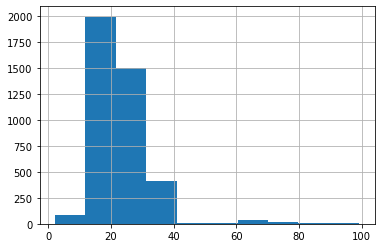

In [159]:
df.iloc[:,5].hist()

In [151]:
df1 = df.copy()
scaler_x = preprocessing.MinMaxScaler()
scaled_values = scaler_x.fit_transform(df1.iloc[:,:5])
df1.iloc[:,:5] = scaled_values

scaler_y = preprocessing.MinMaxScaler()
scaled_values_1 = scaler_y.fit_transform(np.array(df1.iloc[:,5]).reshape(-1,1))
df1.iloc[:,5] = scaled_values_1

In [152]:
model = Sequential()
model.add(Dense(20, input_dim=5))
model.add(Dense(10))
model.add(Dense(5))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

print(model.summary())

model.fit(df1.iloc[:,:5].to_numpy(),df1.iloc[:,5].to_numpy(), epochs=100, batch_size=20, verbose=1)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 20)                120       
                                                                 
 dense_49 (Dense)            (None, 10)                210       
                                                                 
 dense_50 (Dense)            (None, 5)                 55        
                                                                 
 dense_51 (Dense)            (None, 1)                 6         
                                                                 
Total params: 391
Trainable params: 391
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
204/204 [==============================] - 1s 2ms/step - loss: 0.0121 - mse: 0.0121 - mae: 0.0734
Epoch 2/100
204/204 [==============================] - 0s 2ms/step - los

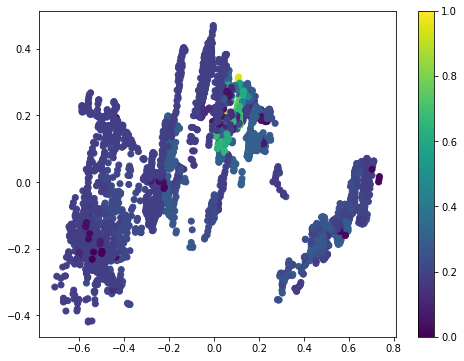

In [153]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca.fit(df1.iloc[:,:5].to_numpy())
x_pca = pca.transform(df1.iloc[:,:5].to_numpy())

plt.figure(figsize =(8, 6)) 
plt.scatter(x_pca[:, 0], x_pca[:, 1], c = df1.iloc[:,5] , cmap ='viridis')
plt.colorbar()

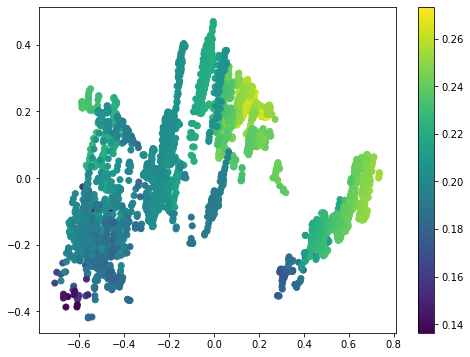

In [154]:
plt.figure(figsize =(8, 6)) 
plt.scatter(x_pca[:, 0], x_pca[:, 1], c = model.predict(df1.iloc[:,:5]) , cmap ='viridis')
plt.colorbar()

In [164]:
ucs = (51 - df.iloc[:,4].min())/(df.iloc[:,4].max()-df.iloc[:,4].min())
measured_depth = (3275 - df.iloc[:,0].min())/(df.iloc[:,0].max()-df.iloc[:,0].min())
# PSO algorithm is applied to find minimum vaue of ANN model for all x,y
n_particles = 20
X = np.random.rand(3, n_particles)
V = np.random.randn(3, n_particles) * 0.01

def pred(X_1):
    result = np.empty((0,), float)
    for i in range(20):
        data = np.array([[measured_depth, X[0,i], X[1,i], X[2,i], ucs]])  
        result = np.append(result, np.array([[model.predict(data)]]).reshape(-1), axis=0)
    return result

pbest = X
pbest_obj = pred(X)
gbest = pbest[:, pbest_obj.argmax()]
gbest_obj = pbest_obj.max()

c1 = c2 = 0.1
w = 0.8

def update():
    global V, X, pbest, pbest_obj, gbest, gbest_obj
    
    r1, r2 = np.random.rand(2)
    V = w * V + c1*r1*(pbest - X) + c2*r2*(gbest.reshape(-1,1)-X)
    X = X + V
    obj = pred(X)
    pbest[:, (pbest_obj >= obj)] = X[:, (pbest_obj >= obj)]
    pbest_obj = np.array([pbest_obj, obj]).max(axis=0)
    gbest = pbest[:, pbest_obj.argmax()]
    gbest_obj = pbest_obj.max()


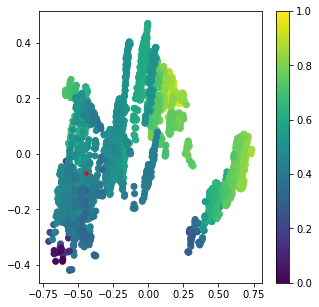

PSO found best solution at f([[3.27500000e+03 2.53444132e+00 2.77644908e+02 2.11396888e+03
  5.10000000e+01]])=[[25.52774584]]


In [165]:
# minimum value of ANN calculated by PSO
from IPython.display import clear_output
import time

k=0
starttime = time.time()

while k<80:
    update()
    
    if k%4 == 0:
        clear_output(wait=True)
        plt.figure(figsize=(5,5))
        plt.scatter(x_pca[:, 0], x_pca[:, 1], c = model.predict(df1.iloc[:,:5]) , cmap ='viridis')
        
        x_pca_1 = np.empty((0,2), float)
        for i in range(20):
            data_1 = np.array([[measured_depth, X[0,i], X[1,i], X[2,i], ucs]])
            x_pca_1 = np.append(x_pca_1, pca.transform(data_1) , axis=0)
         
        plt.scatter(x_pca_1[:, 0], x_pca_1[:, 1], color='red', s=5)
        plt.colorbar()    
        plt.show()
        time.sleep(0.1)
    k=k+1
    
    
print("PSO found best solution at f({})={}".format(scaler_x.inverse_transform(np.array([[measured_depth,gbest[0],gbest[1],gbest[2],ucs]]).reshape(1,-1)), 
                                                   scaler_y.inverse_transform(gbest_obj.reshape(1,-1))))
